<a href="https://colab.research.google.com/github/donna-noble/HPC-Workshop/blob/main/01_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Collection and preprocessing


Repo -> [LSX-UniWue/LLaMmlein](https://github.com/LSX-UniWue/LLaMmlein)

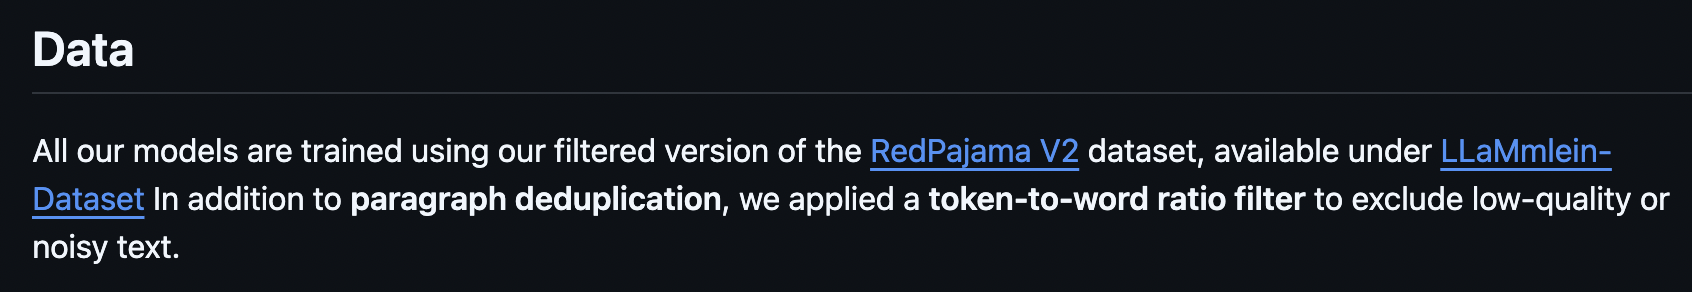

What kind of dataset is important for LLM training and in what format should it be presented



*   token-to-word ratio
*   paragraph deduplication



In [1]:
import re
import string
import hashlib


# 1. Configuration and Data Setup

This sample dataset is designed to illustrate how different types of text behave during preprocessing and deduplication. It includes clean, well-written paragraphs that should be preserved, noisy or symbol-heavy segments that are typical candidates for filtering, and an intentionally duplicated paragraph to demonstrate how normalization and hashing identify repeated content. Using a controlled mixture of normal text, noise, logs and duplicates helps verify that each step of the pipeline behaves correctly before running it at large scale.


In [2]:
data = [
    {
        "text_id": "p-001",
        "text": (
            "Die rote Pyjama-Hose war aus einem Baumwoll-Mischgewebe hergestellt. "
            "Sie kostete 19,99€ und wurde in Größe S bis XL angeboten. "
            "Kundinnen lobten vor allem den angenehmen Stoff und die gute Passform."
        )
    },
    {
        "text_id": "p-002",
        "text": (
            "Normaler, sauberer Text. Ein guter Absatz mit vollständigen Sätzen, "
            "klarer Struktur und ohne ungewöhnliche Symbole. "
            "Solche Abschnitte wollen wir typischerweise im Datensatz behalten."
        )
    },
    {
        "text_id": "p-003",
        "text": (
            "NOISE. "
            + ("!!!@@@###$$$%%%^^^&&&***((()))___+++" * 80) + " "
            + "Mehr NOISE. "
            + ("000111222333444555666777888999" * 40) + " "
            + "Ende."
        )
    },
    {
        "text_id": "p-004",
        "text": (
            "Ein weiterer guter Text mit mehreren Sätzen. "
            "Hier beschreiben wir zum Beispiel einen ganz normalen Zeitungsartikel, "
            "der aus vollständigen, grammatisch korrekten Sätzen besteht. "
            "Es gibt keine unnötigen Sonderzeichen, nur klare Sprache."
        )
    },
    {
        "text_id": "p-005",
        "text": (
            "Kurz. "
            + ("###" * 200)
            + (" @@@!!!???" * 150)
            + " Ein bisschen Text. "
            + ("XYZ123" * 150)
            + " Fertig."
        )
    },
    {
        "text_id": "p-006",
        "text": (
            "Log. "
            "Error Code: [404]. "
            + ("********" * 200)
            + (" &&&&&&&&" * 150)
            + " Einige Wörter dazwischen. "
            + ("0xDEADBEEF 0xCAFEBABE " * 80)
            + " Ende des Logs."
        )
    },
    {
        "text_id": "p-007",
        "text": (
            "Normaler, sauberer Text. Ein guter Absatz, der wie ein kurzer Abschnitt aus einem "
            "Sachbuch oder Nachrichtenartikel wirkt. "
            "Leserinnen und Leser können den Inhalt ohne Ablenkung verstehen."
        )
    },
    {
        #  Intentional duplicate of p-007 (after normalization)
        "text_id": "p-008",
        "text": (
            "   normaler, sauberer text. ein guter absatz, der wie ein kurzer abschnitt aus einem "
            "sachbuch oder nachrichtenartikel wirkt. "
            "leserinnen und leser können den inhalt ohne ablenkung verstehen.   "
        )
    },
    {
        # SMILES example
        "text_id": "p-009",
        "text": (
            "      CC(=O)OC1C[NH+]2CCC1CC2"
            "O=C1CCCN1CC#CCN1CCCC1   "
            "O=C1CCCN1CC#CC[N+](C)(C)C"
        )
    }
]

In [3]:
MAX_TOKEN_TO_WORD_RATIO = 7.0
print(f"Initial Dataset Size: {len(data)}\n")
print(f"Filtering threshold set to: Ratio <= {MAX_TOKEN_TO_WORD_RATIO}\n")


Initial Dataset Size: 9

Filtering threshold set to: Ratio <= 7.0




# 2. Token-to-Word Ratio Calculation

 Token-to-Word Ratio Explanation:

 The ratio (T/W) is a core quality metric that measures the density of non-alphabetic
 characters (noise) within a text.




 Measuring the word to token ratio is important in LLM data preparation because it helps diagnose how efficiently a tokenizer represents the text and reveals whether certain languages or domains are being penalized by high token inflation. A high ratio means the tokenizer is breaking words into many small pieces, which increases sequence length, raises training cost, and can reduce model performance for some languages. By computing word counts, token counts, and their ratio, we gain insight into data efficiency, identify cases where the tokenizer underperforms, and ensure more balanced and cost-effective LLM training.

In [4]:
import re
from transformers import AutoTokenizer

TOKENIZER_NAME = "LSX-UniWue/LLaMmlein_120M_prerelease"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

def calculate_ratio(text: str) -> dict:
    """
    Calculates:
    - Word Count (alphabetic words)
    - Token Count (HF tokenizer)
    - Ratio = tokens / words
    """

    # Word Count (W)
    word_matches = re.findall(r'[a-zA-ZäöüÄÖÜß]+', text)
    word_count = len(word_matches)

    # HuggingFace tokenizer token count
    tokenized = tokenizer.encode(text, add_special_tokens=False)
    token_count = len(tokenized)

    # Ratio (safe)
    ratio = token_count / word_count if word_count > 0 else 0.0

    return {
        "word_count": word_count,
        "token_count": token_count,
        "ratio": ratio
    }

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

# STEP 1: Quality Filtering (Token-to-Word Ratio)

In [5]:
filtered_data = []
quality_filtered_count = 0

print("--- STEP 1: Quality Filtering Log ---")

for entry in data:
    text = entry["text"]
    metrics = calculate_ratio(text)
    ratio = metrics["ratio"]

    if ratio <= MAX_TOKEN_TO_WORD_RATIO:
        entry["metrics"] = metrics
        filtered_data.append(entry)
        quality_filtered_count += 1
        print(f"ACCEPT: ID {entry['text_id']} | Ratio: {ratio:.2f}")
    else:
        # REJECT: Text is considered too noisy.
        print(f"REJECT: ID {entry['text_id']} | Ratio: {ratio:.2f} (NOISY)")

--- STEP 1: Quality Filtering Log ---
ACCEPT: ID p-001 | Ratio: 1.65
ACCEPT: ID p-002 | Ratio: 1.35
REJECT: ID p-003 | Ratio: 663.00 (NOISY)
ACCEPT: ID p-004 | Ratio: 1.39
REJECT: ID p-005 | Ratio: 10.21 (NOISY)
REJECT: ID p-006 | Ratio: 13.98 (NOISY)
ACCEPT: ID p-007 | Ratio: 1.46
ACCEPT: ID p-008 | Ratio: 1.85
ACCEPT: ID p-009 | Ratio: 2.91


# STEP 2: Paragraph Deduplication (Exact Match Hashing)


Paragraph-level deduplication is a crucial preprocessing step in LLM training because duplicate text fragments inflate dataset size without adding new information, bias the model toward overrepresented patterns, and waste compute during training. By splitting documents into paragraphs and removing repeated segments, whether identical documents, repeated boilerplate text, or copy pasted content, we ensure that each training example contributes unique linguistic or factual signal. This improves data quality, reduces training noise, prevents the model from overfitting to duplicated paragraphs, and leads to more efficient and stable training dynamics.

In [6]:
import re
import hashlib
from collections import defaultdict

# Final output after paragraph-level deduplication (same structure as before)
deduplicated_data = []
seen_hashes = set()
duplicates_removed_count = 0

print("\n--- STEP 2: Paragraph-Level Exact Deduplication Log ---")

# Helper function to normalize text before hashing, ensuring that minor
# differences (like capitalization or extra spaces) don't create unique hashes.
def normalize_text(text: str) -> str:
    """Normalize text: remove leading/trailing space and convert to lower case."""
    return text.strip().lower()

# --------------------------------------------------------------------
# STEP 2a: Split each document into paragraphs (paragraph_data)
# --------------------------------------------------------------------
paragraph_data = []

for entry in filtered_data:
    doc_id = entry["text_id"]
    full_text = entry["text"]

    # Split on blank lines (one or more) to get paragraphs.
    # If your data uses single newlines for paragraphs, you can change this.
    if full_text is None:
        continue

    full_text = full_text.strip()
    if not full_text:
        continue

    raw_paragraphs = re.split(r"\n\s*\n+", full_text)

    for idx, para in enumerate(raw_paragraphs):
        para = para.strip()
        if not para:
            continue

        paragraph_data.append({
            "doc_id": doc_id,
            "paragraph_id": f"{doc_id}-p{idx+1}",
            "paragraph_index": idx,
            "text": para,
        })

# --------------------------------------------------------------------
# STEP 2b: Paragraph-level exact deduplication via SHA-256
# --------------------------------------------------------------------
deduplicated_paragraphs = []

for p in paragraph_data:
    normalized_text = normalize_text(p["text"])
    text_hash = hashlib.sha256(normalized_text.encode("utf-8")).hexdigest()

    if text_hash not in seen_hashes:
        # Paragraph is unique: keep it and mark the hash as seen.
        seen_hashes.add(text_hash)
        deduplicated_paragraphs.append(p)
        print(
            f"KEEP: paragraph_id={p['paragraph_id']} "
            f"(doc_id={p['doc_id']}) | Unique hash."
        )
    else:
        # Paragraph is a duplicate: discard it.
        duplicates_removed_count += 1
        print(
            f"REJECT: paragraph_id={p['paragraph_id']} "
            f"(doc_id={p['doc_id']}) | Duplicate hash detected. Removed."
        )

# --------------------------------------------------------------------
# STEP 2c: Reconstruct documents from deduplicated paragraphs
# --------------------------------------------------------------------
docs = defaultdict(list)

for p in deduplicated_paragraphs:
    docs[p["doc_id"]].append((p["paragraph_index"], p["text"]))

for doc_id, paras in docs.items():
    # Sort paragraphs by original position in the document
    paras_sorted = sorted(paras, key=lambda x: x[0])
    merged_text = "\n\n".join(text for _, text in paras_sorted)

    deduplicated_data.append({
        "text_id": doc_id,
        "text": merged_text,
    })

print(f"\nTotal duplicate paragraphs removed: {duplicates_removed_count}")
print(f"Documents after paragraph-level deduplication: {len(deduplicated_data)}")


--- STEP 2: Paragraph-Level Exact Deduplication Log ---
KEEP: paragraph_id=p-001-p1 (doc_id=p-001) | Unique hash.
KEEP: paragraph_id=p-002-p1 (doc_id=p-002) | Unique hash.
KEEP: paragraph_id=p-004-p1 (doc_id=p-004) | Unique hash.
KEEP: paragraph_id=p-007-p1 (doc_id=p-007) | Unique hash.
REJECT: paragraph_id=p-008-p1 (doc_id=p-008) | Duplicate hash detected. Removed.
KEEP: paragraph_id=p-009-p1 (doc_id=p-009) | Unique hash.

Total duplicate paragraphs removed: 1
Documents after paragraph-level deduplication: 5


# 3. Final Summary


The pipeline started with 9 paragraphs and reduced them to 5 after quality filtering, removing heavy-noise segments and low-value text. After paragraph-level deduplication, the final dataset contained 4 unique, clean paragraphs, with 1 exact duplicate successfully detected and removed. In total, 4 paragraphs were filtered out across all steps, leaving a compact and high-quality set of texts suitable for LLM training.

In [7]:
total_removed = len(data) - len(deduplicated_data)

print("\n--- Final Pipeline Summary ---")
print(f"A. Paragraphs Before Filtering: {len(data)}")
print(f"B. Paragraphs After Quality Filtering (Step 1): {len(filtered_data)}")
print(f"C. Paragraphs After Exact Deduplication (Step 2): {len(deduplicated_data)}")
print("-" * 35)
print(f"Total paragraphs removed: {total_removed}")
print(f"Duplicates removed in Step 2: {duplicates_removed_count}")

print("\nFirst 2 Final Clean Paragraphs:")
for item in deduplicated_data[:2]:
    print(f"  ID: {item['text_id']}, Text: \"{item['text'][:35]}...\"")


--- Final Pipeline Summary ---
A. Paragraphs Before Filtering: 9
B. Paragraphs After Quality Filtering (Step 1): 6
C. Paragraphs After Exact Deduplication (Step 2): 5
-----------------------------------
Total paragraphs removed: 4
Duplicates removed in Step 2: 1

First 2 Final Clean Paragraphs:
  ID: p-001, Text: "Die rote Pyjama-Hose war aus einem ..."
  ID: p-002, Text: "Normaler, sauberer Text. Ein guter ..."
